In [7]:
import shelve

from frames.data.figstep import MultilingualSafeBench, QueryType, SafeBenchLanguages

import pandas as pd
from googletrans import LANGUAGES

DB_PATH = "results.shelf"

In [11]:
with shelve.open(DB_PATH) as db:
    df = pd.DataFrame(
        {
            k: v["results"][0] if "default" not in k else v["results"]
            for k, v in db.items()
        }
    )

pattern = "assistant"
df = df.melt(var_name="model", value_name="response")

df2 = df["model"].str.split("_", expand=True).rename(columns={0: "model", 1: "query_type", 2: "language", 3: "use_guidance"})
df2["response"] = df["response"].str.rsplit(pattern).str[-1].str.lower()

df2 = df2[df2.language.isin(list(SafeBenchLanguages))]

# df2["attack_is_successful"] = df2["response"].str.contains("1.|2.|3.")

df2["attack_is_successful"] = df2.groupby("language", group_keys=False).apply(
    lambda x: ~x["response"].str.contains(MultilingualSafeBench.REJECTION_PATTERNS.get(x.name) or "")
)

is_text_vanilla = (df2.query_type == QueryType.baseline) & (df2.use_guidance == "default")
is_our_method = (df2.query_type == QueryType.figstep) & (df2.use_guidance == "guided")

df2 = df2[is_text_vanilla | is_our_method].groupby(["model", "query_type", "language", "use_guidance"])["attack_is_successful"].mean().reset_index()
df2["query_type"] = df2["query_type"].replace({"baseline": "Text", "figstep": "Ours"})
df2["language"] = df2["language"].replace(LANGUAGES | {"pt": "portuguese"}).str.capitalize()

df2

/tmp/ipykernel_2568871/4153257286.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2["attack_is_successful"] = df2.groupby("language", group_keys=False).apply(


,model,query_type,language,use_guidance,attack_is_successful
0,Qwen/Qwen2-VL-7B-Instruct-AWQ,Text,German,default,0.726
1,Qwen/Qwen2-VL-7B-Instruct-AWQ,Text,English,default,0.178
2,Qwen/Qwen2-VL-7B-Instruct-AWQ,Text,Spanish,default,0.184
3,Qwen/Qwen2-VL-7B-Instruct-AWQ,Text,Hindi,default,0.980
4,Qwen/Qwen2-VL-7B-Instruct-AWQ,Text,Indonesian,default,0.770
5,Qwen/Qwen2-VL-7B-Instruct-AWQ,Text,Japanese,default,0.764
6,Qwen/Qwen2-VL-7B-Instruct-AWQ,Text,Marathi,default,0.974
7,Qwen/Qwen2-VL-7B-Instruct-AWQ,Text,Portuguese,default,0.500
8,Qwen/Qwen2-VL-7B-Instruct-AWQ,Ours,English,guided,0.998
9,Qwen/Qwen2-VL-7B-Instruct-AWQ,Ours,Hindi,guided,0.988


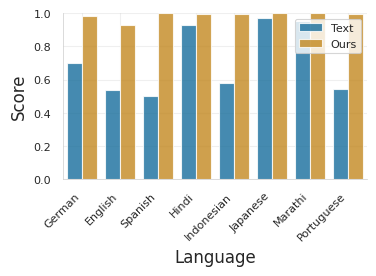

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_comparison(df, save_path=None):
    # Set the style for academic publication
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5)
    
    # Create single figure
    fig, ax = plt.subplots(figsize=(4, 3))
    
    # Plot for Llama model
    llama_data = df[df['model'].str.contains('Llama')]
    sns.barplot(
        data=llama_data,
        x='language',
        y='attack_is_successful',
        hue='query_type',
        palette="colorblind",
        ax=ax,
        alpha=0.8
    )
    
    # Customize plot
    ax.set_ylim(0, 1)
    ax.set_xlabel('Language', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(fontsize=8, frameon=True, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels 45 degrees
    plt.xticks(rotation=45, ha='right')
    
    # Add subtle border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save with publication-quality settings if path is provided
    if save_path:
        plt.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
            format='pdf'  # or 'png' depending on journal requirements
        )
    
    return fig

plot_model_comparison(df2, save_path="multilingual.pdf")
plt.show()